# TSAI Assignment

## Session 2.5 - PyTorch 101


1. Write a neural network that
   a. can take 2 inputs:

   1. an image from the MNIST dataset (say 5), and
   2. a random number between 0 and 9, (say 7)

   b. and gives 2 outputs:

   1. the "number" that was represented by the MNIST image (predict 5), and
   2. the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)

2. You can mix fully connected layers and convolution layers

3. You can use one-hot encoding to represent the random umber input as well as the "summed" output.

4. **Your code MUST be** - well documented (via readme file on github and comments in the code) - must mention the data representation - must mention your data generation strategy (basically the class/method you are using for random number generation) - must mention how you have combined the two inputs (basically which layer you are combining) - must mention how you are evaluating your results - must mention "what" results you finally got and how did you evaluate your results - must mention what loss function you picked and why!

5. Training MUST happen on the PU

6. Accuracy is not really important for the UM

7. Once done, upload the code with short trining logs in the readme file from colab to GitHub, and share the GitHub lik (public repository

## Install Requirements and Import

In [234]:
! pip install pytorch-lightning --quiet
! pip install torchmetrics --quiet

In [244]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

import torchmetrics

## Custom Dataset Class

In [236]:
class CustomDataset(MNIST):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def __getitem__(self, index):
    img, target = super().__getitem__(index)

    rand_number = np.random.randint(low=0, high=10)
    encoded_rand_number = F.one_hot(torch.tensor(rand_number),
                                    num_classes=10)

    encoded_sum = F.one_hot(torch.tensor(target + rand_number),
                            num_classes=29)

    if not isinstance(img, (torch.Tensor, np.ndarray)):
      img = np.array(img)
    
    return ((img, encoded_rand_number), (target, encoded_sum))

In [237]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, root, batch_size=128, num_workers=2):
      super().__init__()
      
      self.root = root
      self.batch_size = batch_size
      self.num_workers = num_workers

      self.train_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Lambda(lambda x: (x / 255).float())
      ])
      self.val_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Lambda(lambda x: (x / 255).float())
      ])
        
    def prepare_data(self):
      # download, split, etc...
      # only called on 1 GPU/TPU in distributed
      CustomDataset(self.root, train=True, download=True)
      CustomDataset(self.root, train=False, download=True)
    
    def setup(self, stage):
      # make assignments here (val/train/test split)
      # called on every process in DDP

      self.train_data = CustomDataset(
        self.root,
        train=True, 
        download=False,
        transform=self.train_transform)
      
      self.val_data = CustomDataset(
        self.root,
        train=False,
        download=False,
        transform=self.val_transform)

    def train_dataloader(self):
      return DataLoader(
        self.train_data,
        batch_size=self.batch_size,

        num_workers=self.num_workers,
        pin_memory=True,
        drop_last=True)
    
    def val_dataloader(self):
      return DataLoader(
        self.val_data,
        batch_size=self.batch_size,

        num_workers=self.num_workers,
        pin_memory=True,
        drop_last=True)
  

## Custom Network Class

In [238]:
class CustomNetwork(pl.LightningModule):
  def __init__(self, lr=0.1, dropout_val=0.1, epochs=10): 
    super().__init__()
    self.save_hyperparameters()

    self.val_sum_accuracy = torchmetrics.Accuracy()
    self.val_mnist_accuracy = torchmetrics.Accuracy()

    self.loss_fn = nn.CrossEntropyLoss()


    block1 = lambda in_channels, out_channels, kernel_size: [
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
      nn.Dropout(self.hparams.dropout_val),
    ]

    block2 = lambda in_channels, out_channels, kernel_size, pool_size: [
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size),
      nn.MaxPool2d(pool_size),
    ]

    self.mnist_encoder = nn.Sequential(
        # input size 1X28x28
        *block1(1, 10, (3,3)),
        
        # input size 10X26X26
        *block1(10, 30, (3,3)),

        # input size 30X24X24
        *block2(30, 15, (1, 1), (2,2)),

        # input size 15X12X12
        *block1(15, 15, (3,3)),

        # input size 15X10X10
        *block1(15, 15, (3,3)),

        # input size 15X8X8
        *block1(15, 15, (3,3)),

        # input size 15X6X6
        nn.AvgPool2d((6,6)),

        # input size 15X1X1
        nn.Flatten()
        
        # output size 15
    )

    block3 = lambda in_channels, out_channels: [
      nn.Linear(in_channels, out_channels, bias=False),
      nn.ReLU(),
      nn.BatchNorm1d(out_channels),
      nn.Dropout(self.hparams.dropout_val),
    ]

    self.encoder = nn.Sequential(
        *block3(15+10, 40),
        *block3(40, 40)
    )

    self.mnist_decode = nn.Sequential(
        nn.Linear(40, 10, bias=False)
    )

    self.sum_decode = nn.Sequential(
        nn.Linear(40, 19, bias=False)
    )

  
  def forward(self, img, encoded_rand_number):
    x = self.mnist_encoder(img)
    x = torch.cat([x, encoded_rand_number], -1)
    x = self.encoder(x)

    mnist_out = self.mnist_decode(x)
    sum_out = self.sum_decode(x)
    return mnist_out, sum_out

  def training_step(self, train_batch, batch_idx):
    (img, encoded_rand_number), (target, encoded_sum) = train_batch
    mnist_pred, sum_pred = self.forward(img, encoded_rand_number)
    decoded_sum = torch.argmax(encoded_sum, dim=1)

    mnist_loss = self.loss_fn(mnist_pred, target)
    sum_loss = self.loss_fn(sum_pred, decoded_sum)
    loss = mnist_loss + sum_loss

    self.log("mnist training loss", mnist_loss)
    self.log("sum training loss", sum_loss)
    self.log("total training loss", loss)
    
    return loss

  def validation_step(self, valid_batch, batch_idx): 
    (img, encoded_rand_number), (target, encoded_sum) = valid_batch

    # Get Predicted Output
    mnist_pred, sum_pred = self.forward(img, encoded_rand_number)
    decoded_sum = torch.argmax(encoded_sum, dim=1)

    mnist_loss = self.loss_fn(mnist_pred, target)
    sum_loss = self.loss_fn(sum_pred, decoded_sum)
    loss = mnist_loss + sum_loss

    decoded_mnist_pred = torch.argmax(F.log_softmax(mnist_pred, dim=1), dim=1)
    decoded_sum_pred = torch.argmax(F.log_softmax(sum_pred, dim=1), dim=1)
    
    self.val_mnist_accuracy(decoded_mnist_pred, target)
    self.val_sum_accuracy(decoded_sum_pred, decoded_sum)

    self.log("mnist validation loss", mnist_loss, prog_bar=True)
    self.log("sum validation loss", sum_loss, prog_bar=True)
    self.log("total validation loss", loss, prog_bar=True)
    self.log("mnist validation acc", self.val_mnist_accuracy, on_step=True, on_epoch=True, prog_bar=True)
    self.log("sum validation acc", self.val_sum_accuracy, on_step=True, on_epoch=True, prog_bar=True)

    return loss

  def configure_optimizers(self): 
    # return torch.optim.SGD(self.parameters(), lr=self.lr)
    optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
                    optimizer,
                    max_lr=self.hparams.lr,
                    steps_per_epoch=int(len(self.train_dataloader())),
                    epochs=self.hparams.epochs,
                    anneal_strategy="linear",
                    final_div_factor = 30)
    
    scheduler = {
      # REQUIRED: The scheduler instance
      "scheduler": lr_scheduler,
      # The unit of the scheduler's step size, could also be 'step'.
      # 'epoch' updates the scheduler on epoch end whereas 'step'
      # updates it after a optimizer update.
      "interval": "step",
      # How many epochs/steps should pass between calls to
      # `scheduler.step()`. 1 corresponds to updating the learning
      # rate after every epoch/step.
      "frequency": 1,
      # Metric to to monitor for schedulers like `ReduceLROnPlateau`
      # "monitor": "val_loss",
      # If set to `True`, will enforce that the value specified 'monitor'
      # is available when the scheduler is updated, thus stopping
      # training if not found. If set to `False`, it will only produce a warning
      # "strict": True,
      # If using the `LearningRateMonitor` callback to monitor the
      # learning rate progress, this keyword can be used to specify
      # a custom logged name
      "name": "one_cycle_lr",
    }
    
    return [optimizer], [scheduler]


## TRAIN AND TEST

In [239]:
config = {
  "lr": 0.01,
  "dropout_val": 0.1,
  "epochs": 10
} 

data_module = CustomDataModule("dataset")

model = CustomNetwork(**config) 

trainer = pl.Trainer(
  gpus=1,
  max_epochs=config["epochs"],
  progress_bar_refresh_rate=20,
) 

# trainer.fit(model, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | val_sum_accuracy   | Accuracy         | 0     
1 | val_mnist_accuracy | Accuracy         | 0     
2 | loss_fn            | CrossEntropyLoss | 0     
3 | mnist_encoder      | Sequential       | 9.5 K 
4 | encoder            | Sequential       | 2.8 K 
5 | mnist_decode       | Sequential       | 400   
6 | sum_decode         | Sequential       | 760   
--------------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.054     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /content/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /content/lr_find_temp_model.ckpt


lr_finder.results =  {'lr': [1e-08, 1.492723603461587e-08, 1.8237659375231342e-08, 2.2282237563313445e-08, 2.722378462130032e-08, 3.3261221948696366e-08, 4.0637585879769546e-08, 4.964981108279366e-08, 6.066068363042928e-08, 7.411344491069478e-08, 9.054963425725768e-08, 1.1063088855204407e-07, 1.3516557634062242e-07, 1.6514133861356448e-07, 2.0176484617913606e-07, 2.4651037405571e-07, 3.011791482403928e-07, 3.67971853851103e-07, 4.4957722344889053e-07, 5.49280271653059e-07, 6.710945330208825e-07, 8.199236264123132e-07, 1.001758649594303e-06, 1.2239193501814797e-06, 1.4953487812212206e-06, 1.8269733027492629e-06, 2.2321424211364327e-06, 2.727166171907997e-06, 3.3319716783182443e-06, 4.070905315369043e-06, 4.973712770291162e-06, 6.076736451708607e-06, 7.424378449051936e-06, 9.070887933480851e-06, 1.1082544951931345e-05, 1.3540328522661751e-05, 1.654317643617198e-05, 2.0211967984401358e-05, 2.469438994250346e-05, 3.0170881682725832e-05, 3.6861898740259296e-05, 4.5036787225051646e-05, 5.502

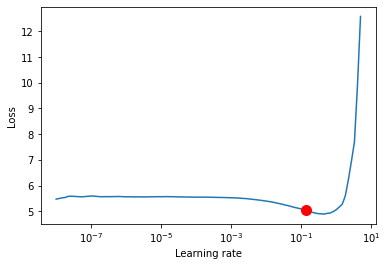

In [240]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model, data_module, max_lr=5)

# Results can be found in
print("lr_finder.results = ", lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

In [241]:
# Fit model
trainer.fit(model,data_module )

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | val_sum_accuracy   | Accuracy         | 0     
1 | val_mnist_accuracy | Accuracy         | 0     
2 | loss_fn            | CrossEntropyLoss | 0     
3 | mnist_encoder      | Sequential       | 9.5 K 
4 | encoder            | Sequential       | 2.8 K 
5 | mnist_decode       | Sequential       | 400   
6 | sum_decode         | Sequential       | 760   
--------------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.054     Total estima

Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18b6d3eef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18b6d3eef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [246]:
def infer_and_plot_output(sample_data, model):
    model = model.eval()
    
    (mnist_img, adder_num), (mnist_target, adder_target) = sample_data
    
    with torch.no_grad():
        mnist_pred, adder_pred = model(mnist_img, adder_num)
        mnist_pred, adder_pred = torch.argmax(mnist_pred, dim=1), torch.argmax(adder_pred, dim=1)

    num_images = 25
    fig = plt.figure(figsize=(12, 15))

    assert len(mnist_img[0] >= 25), "need atleast 25 images in `sample_data`"

    fig.suptitle('MNIST and Adder')

    for idx in range(0, 25):

        image = mnist_img[idx].cpu().numpy()
        add_num = torch.argmax(adder_num, dim=1)[idx].cpu().item()
        
        image_target = mnist_target[idx].cpu().item()
        add_target = torch.argmax(adder_target, dim=1)[idx].cpu().item()
        
        image_pred = mnist_pred[idx].cpu().item()
        add_pred = adder_pred[idx].cpu().item()

        isvalid = (image_target == image_pred) and (add_target == add_pred)
        isvalid = str(isvalid).upper()

        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.imshow(mnist_img[idx].squeeze())
        ax.set_title(f'target: {image_target} + {add_num} = {add_target}'+
                     f'\npred: {image_pred} + {add_num} = {add_pred}'+ 
                     f'\nValid: {isvalid}'
                     )

    plt.show()

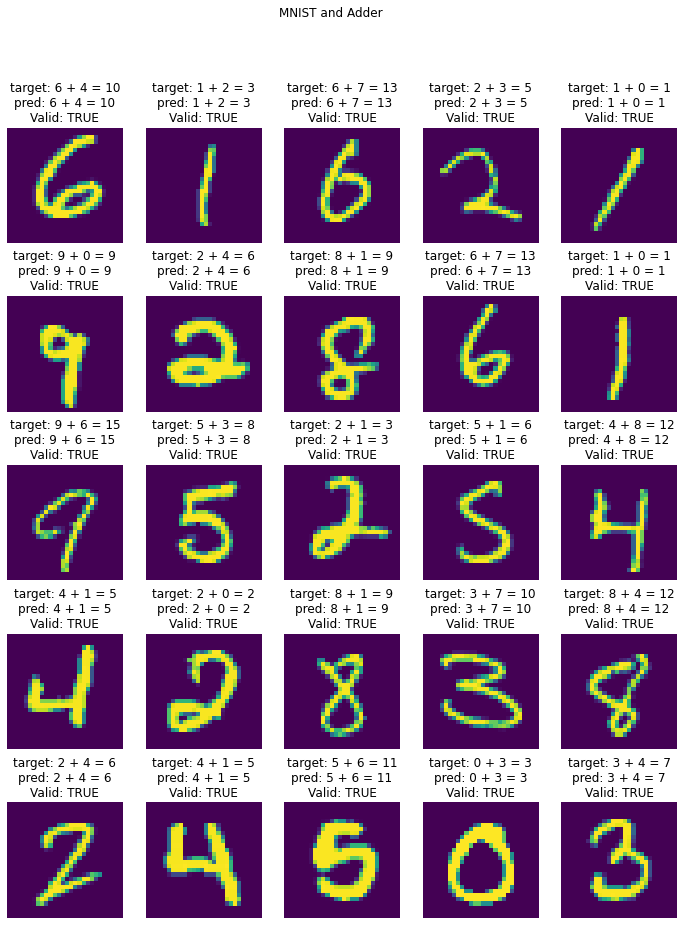

In [247]:
it = iter(data_module.val_dataloader())
next(it)
next(it)
next(it)
sample = next(it)
infer_and_plot_output(sample, model)